In [1]:
import pypsa
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import requests
from datetime import datetime, timedelta
import calendar
from io import StringIO
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt

In [2]:
# Load the Excel file
file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Wind Generation/Ramboll Data_Wind Generation Data 2022.xlsx'
df = pd.read_excel(file_path, skiprows=2)

# Rename columns to make them easier to work with
df.columns = ['Index', 'Date', 'Daily Total'] + [f'k Wh{i}' for i in range(1, 49)]

# Filter the rows for the year 2022
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df[df['Date'].dt.year == 2022]

# Now, we need to sum the columns as per the provided instructions and reformat the dataframe
rows = []
for index, row in df.iterrows():
    date = row['Date']
    for i in range(24):
        timestamp = date + pd.Timedelta(hours=i)
        wind_power_output = row[f'k Wh{i*2+1}'] + row[f'k Wh{i*2+2}']
        rows.append([timestamp, wind_power_output])

# Create a new DataFrame with the processed data
new_df = pd.DataFrame(rows, columns=['Timestamp', 'Wind Power Output (kW)'])

# Remove rows after 2022-12-31 00:00:00
new_df = new_df[new_df['Timestamp'] <= '2022-12-31 00:00:00']

# Remove the row for 2022-01-01 00:00:00
new_df = new_df[new_df['Timestamp'] != '2022-01-01 00:00:00']

# Save the new dataframe to an Excel file
new_file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Wind Generation/Wind_Generation_Company_2022.xlsx'
new_df.to_excel(new_file_path, index=False)

print(f"Processed data saved to: {new_file_path}")


/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/ipykernel_91649/3741023522.py:9: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



Processed data saved to: /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Wind Generation/Wind_Generation_Company_2022.xlsx


In [3]:
# Step 1: Load the Excel file
demand_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Wind Demand/National_Demand_UK_2022.xlsx'
demand_df = pd.read_excel(demand_path)

# Step 2: Sum the 'ND' values for each pair of SETTLEMENT_PERIOD in each day using the provided method
demand_df['SETTLEMENT_DATE'] = pd.to_datetime(demand_df['SETTLEMENT_DATE'])

rows = []
for date, group in demand_df.groupby('SETTLEMENT_DATE'):
    for i in range(24):
        timestamp = date + pd.Timedelta(hours=i)
        period_1 = i * 2 + 1
        period_2 = i * 2 + 2
        nd_1 = group.loc[group['SETTLEMENT_PERIOD'] == period_1, 'ND'].values
        nd_2 = group.loc[group['SETTLEMENT_PERIOD'] == period_2, 'ND'].values
        if nd_1.size > 0 and nd_2.size > 0:
            load_demand = nd_1[0] + nd_2[0]
            rows.append([timestamp, load_demand])
        else:
            rows.append([timestamp, None])

summed_demand_df = pd.DataFrame(rows, columns=['Timestamp', 'Load Demand (MW)'])

# Step 3: Cut all 'Timestamp' after 2022-12-31 00:00:00
summed_demand_df = summed_demand_df[summed_demand_df['Timestamp'] <= '2022-12-31 00:00:00']

# Step 4: Save the intermediate summed demand data
output_summed_demand_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Wind Demand/Demand_UK_2022_Final.xlsx'
summed_demand_df.to_excel(output_summed_demand_path, index=False)

# Step 5: Load the wind generation data and cut all 'Timestamp' after 2022-12-31 00:00:00
wind_gen_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Wind Generation/Wind_Generation_Company_2022.xlsx'
wind_gen_df = pd.read_excel(wind_gen_path)
wind_gen_df = wind_gen_df[wind_gen_df['Timestamp'] <= '2022-12-31 00:00:00']

# Step 6: Convert 'Wind Power Output' from kW to MW
wind_gen_df['Wind Power Output (MW)'] = wind_gen_df['Wind Power Output (kW)'] / 1000
wind_gen_df.drop(columns=['Wind Power Output (kW)'], inplace=True)

# Step 7: Add 'Load Demand (MW)' column to the wind generation data and save the final file
# Merge the demand data with the wind generation data on 'Timestamp'
final_df = pd.merge(wind_gen_df, summed_demand_df, on='Timestamp', how='left')

# Save the final file with specified title heads
final_output_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Wind Generation/Wind_Generation_Data_Input_2022.xlsx'
final_df.to_excel(final_output_path, index=False, columns=['Timestamp', 'Wind Power Output (MW)', 'Load Demand (MW)'])

print(f'Data successfully saved to {final_output_path}')


Data successfully saved to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Wind Generation/Wind_Generation_Data_Input_2022.xlsx


In [4]:
# Step 1: Load the Excel file
demand_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Wind Demand/National_Demand_UK_2022.xlsx'
demand_df = pd.read_excel(demand_path)

# Step 2: Delete rows with SETTLEMENT_PERIOD in the specified range
settlement_periods_to_remove = list(range(1, 48, 2))
demand_df = demand_df[~demand_df['SETTLEMENT_PERIOD'].isin(settlement_periods_to_remove)]

# Step 3: Keep only the 'ND' column
demand_df = demand_df[['ND']]

# Step 4: Rename 'ND' to 'Load Demand (MW)'
demand_df.rename(columns={'ND': 'Load Demand (MW)'}, inplace=True)

# Step 5: Add 'Timestamp' column with hourly intervals starting from 2022-01-01 00:00:00
demand_df['Timestamp'] = pd.date_range(start='2022-01-01 01:00:00', periods=len(demand_df), freq='h')
demand_df = demand_df[['Timestamp', 'Load Demand (MW)']]

# Step 6: Cut all 'Timestamp' after 2022-12-31 00:00:00
demand_df = demand_df[demand_df['Timestamp'] <= '2022-12-31 00:00:00']

# Step 7: Save the Excel sheet under the specified name and path
output_demand_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Wind Demand/Demand_UK_2022_Final_for_plot_only.xlsx'
demand_df.to_excel(output_demand_path, index=False)

print(f'Data successfully saved to {output_demand_path}')

Data successfully saved to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Wind Demand/Demand_UK_2022_Final_for_plot_only.xlsx


In [5]:
# Elexon API endpoint and API key
api_url = 'https://data.elexon.co.uk/bmrs/api/v1/balancing/pricing/market-index'
api_key = 't3nj6h9ockem80q'  # Provided API key

# Function to fetch data for a specific date range
def fetch_data_for_month(year, month):
    # Determine the number of days in the month
    num_days = calendar.monthrange(year, month)[1]

    # Initialize variables
    data_all = []

    # Headers
    headers = {
        'accept': 'text/csv',
        'x-api-key': api_key}

    # Iterate over each week of the month
    current_date = datetime(year, month, 1)
    while current_date.month == month:
        end_date = current_date + timedelta(days=6)
        if end_date.month != month:
            end_date = datetime(year, month, num_days)

        params = {
            'from': current_date.strftime('%Y-%m-%dT00:00Z'),
            'to': end_date.strftime('%Y-%m-%dT23:59Z'),
            'dataProviders': 'APXMIDP',  # Changed from N2EXMIDP to APXMIDP
            'format': 'csv'}
        try:
            # Make GET request
            response = requests.get(api_url, params=params, headers=headers)

            # Check if request was successful
            if response.status_code == 200:
                # Append the fetched data to the list
                data_all.append(response.text)
            else:
                print(f"Error fetching data for {current_date.date()} to {end_date.date()}: {response.status_code} - {response.text}")
        except requests.exceptions.RequestException as e:
            print(f"Error fetching data for {current_date.date()} to {end_date.date()}: {e}")
        current_date = end_date + timedelta(days=1)
    return data_all

# Function to save data to an Excel file
def save_to_excel(data, filename, year):
    # Combine all data into a single DataFrame
    combined_data = pd.concat([pd.read_csv(StringIO(block)) for block in data], ignore_index=True)
    
    # Rename the 'StartTime' column to 'Timestamp'
    if 'StartTime' in combined_data.columns:
        combined_data.rename(columns={'StartTime': 'Timestamp'}, inplace=True)
    
    # Format the 'Timestamp' column to YYYY-MM-DD HH:MM:SS
    if 'Timestamp' in combined_data.columns:
        combined_data['Timestamp'] = pd.to_datetime(combined_data['Timestamp']).dt.strftime('%Y-%m-%d %H:%M:%S')
    
    # Drop specified columns
    columns_to_drop = ['SettlementDate', 'SettlementPeriod', 'Volume']
    combined_data.drop(columns=[col for col in columns_to_drop if col in combined_data.columns], inplace=True)
    
    # Create a complete DataFrame of all possible timestamps for the year up to YYYY-12-31 00:00:00
    all_timestamps = pd.date_range(start=f'{year}-01-01 01:00:00', end=f'{year}-12-31 00:00:00', freq='h').strftime('%Y-%m-%d %H:%M:%S')
    all_timestamps_df = pd.DataFrame(all_timestamps, columns=['Timestamp'])
    
    # Merge the combined data with the all timestamps DataFrame
    final_data = pd.merge(all_timestamps_df, combined_data, on='Timestamp', how='left')
    
    # Fill missing data with the value from the previous day at the same hour
    for index, row in final_data.iterrows():
        if pd.isna(row).any():
            prev_day_timestamp = (pd.to_datetime(row['Timestamp']) - timedelta(days=1)).strftime('%Y-%m-%d %H:%M:%S')
            prev_day_value = final_data.loc[final_data['Timestamp'] == prev_day_timestamp].drop(columns=['Timestamp'])
            if not prev_day_value.empty:
                final_data.loc[index, prev_day_value.columns] = prev_day_value.values[0]
    
    # Rename the price column to 'Price (£/MWh)' if it exists
    if 'Price' in final_data.columns:
        final_data.rename(columns={'Price': 'Price (£/MWh)'}, inplace=True)
    
    # Sort the data by 'Timestamp' in ascending order
    final_data.sort_values(by='Timestamp', ascending=True, inplace=True)
    
    # Save to Excel file
    final_data.to_excel(filename, index=False)

# Example: Fetch data for the entire year and save to Excel file
year = 2022
all_data = []

for month in range(1, 13):
    data_for_month = fetch_data_for_month(year, month)
    all_data.extend(data_for_month)

# Specify the filename to save
excel_filename = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Electricity Price/Merged_Electricity_Prices_2022.xlsx'

# Save data to Excel file
save_to_excel(all_data, excel_filename, year)

print(f"Data saved to {excel_filename}")


Data saved to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Electricity Price/Merged_Electricity_Prices_2022.xlsx


In [6]:
# Load the data from the uploaded Excel file
file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Electricity Price/Merged_Electricity_Prices_2022.xlsx'
electricity_prices_df = pd.read_excel(file_path)

# Convert the 'Timestamp' column to datetime format
electricity_prices_df['Timestamp'] = pd.to_datetime(electricity_prices_df['Timestamp'])

# Add a column for the date
electricity_prices_df['Date'] = electricity_prices_df['Timestamp'].dt.date

# Sort the dataframe by Date and Price in descending order
electricity_prices_df_sorted = electricity_prices_df.sort_values(by=['Date', 'Price (£/MWh)'], ascending=[True, False])

# Group by Date and take the top 6 prices for each day
top_6_prices_per_day = electricity_prices_df_sorted.groupby('Date').head(6).reset_index(drop=True)

# Define the file path for the output Excel file
output_file_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Electricity Price/Top_6_Electricity_Prices_Per_Day_2022.xlsx'

# Save the result to an Excel file
top_6_prices_per_day.to_excel(output_file_path, index=False)

print(f"Top 6 electricity prices per day have been saved to {output_file_path}")

# Find the most common timestamps for these highest prices
most_common_timestamps = top_6_prices_per_day['Timestamp'].dt.time.value_counts().head(6)

# Display the most common timestamps with highest prices
print("The most common timestamps with the highest prices are:")
for timestamp, count in most_common_timestamps.items():
    print(f"{timestamp} - {count} occurrences")


Top 6 electricity prices per day have been saved to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Electricity Price/Top_6_Electricity_Prices_Per_Day_2022.xlsx
The most common timestamps with the highest prices are:
18:00:00 - 294 occurrences
17:00:00 - 258 occurrences
19:00:00 - 257 occurrences
20:00:00 - 182 occurrences
16:00:00 - 166 occurrences
07:00:00 - 127 occurrences


In [7]:
# Define the year for which you want the cost data
year = 2020

# URL to fetch the cost data
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"

# Read the cost data
costs = pd.read_csv(url, index_col=[0, 1])

# Convert units
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

# Define default values
defaults = {
    "FOM": 0,  # Fixed O&M costs
    "VOM": 0,  # Variable O&M costs
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}

# Fill missing values with defaults
costs = costs.value.unstack().fillna(defaults)

# Utility function to calculate annuity
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

# Calculate annuity
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)

# Calculate the annualised investment costs (capital_cost in PyPSA terms, €/MW/a)
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

# Extract the capital costs
battery_capital_cost = costs.loc["battery storage", "capital_cost"]
battery_inverter_capital_cost = costs.loc["battery inverter", "capital_cost"]
wind_turbine_capital_cost = costs.loc["solar", "capital_cost"]
backup_generator_capital_cost = costs.loc["OCGT", "capital_cost"]

battery_capital_lifetime = costs.loc["battery storage", "lifetime"]
battery_inverter_capital_lifetime = costs.loc["battery inverter", "lifetime"]
onwind_lifetime = costs.loc["onwind", "lifetime"]
backup_generator_lifetime = costs.loc["OCGT", "lifetime"]

# Convert capital costs from Euros to UK pounds
exchange_rate = 0.85  # 1 Euro = 0.85 UK pounds
battery_capital_cost_gbp = battery_capital_cost * exchange_rate * battery_capital_lifetime
battery_inverter_capital_cost_gbp = battery_inverter_capital_cost * exchange_rate * battery_inverter_capital_lifetime

Final_battery_capital_cost_gbp = battery_inverter_capital_cost_gbp + 2 * battery_capital_cost_gbp 
wind_turbine_capital_cost_gbp = wind_turbine_capital_cost * exchange_rate * onwind_lifetime
backup_generator_capital_cost_gbp = backup_generator_capital_cost * exchange_rate * backup_generator_lifetime * 3

print(f"Battery Capital Cost (£/MW): {battery_capital_cost_gbp}")
print(f"Battery Inverter Cost (£/MW): {battery_inverter_capital_cost_gbp}")
print(f"Total Battery Storage Capital Cost (£/MW): {Final_battery_capital_cost_gbp}")
print(f"Total Wind Turbine Capital Cost (£/MW): {wind_turbine_capital_cost_gbp}")
print(f"Total Backup Generator Capital Cost (£/MW): {backup_generator_capital_cost_gbp}")

# Prepare data for export

data = {
    "Item": ["Capital Cost (£/MW)"],
    "Battery Initital Capital Cost": [battery_capital_cost_gbp],
     "Battery Inverter Cost": [battery_inverter_capital_cost_gbp],
    "Final Battery Storage Capital Cost": [Final_battery_capital_cost_gbp],
    "Wind Turbine Capital Cost": [wind_turbine_capital_cost_gbp],
    "Backup Generator Capital Cost": [backup_generator_capital_cost_gbp]
}


Battery Capital Cost (£/MW): 393960.7502195361
Battery Inverter Cost (£/MW): 350637.84523197776
Total Battery Storage Capital Cost (£/MW): 1138559.3456710498
Total Wind Turbine Capital Cost (£/MW): 1728681.257930769
Total Backup Generator Capital Cost (£/MW): 3172202.328302408


In [8]:
def delete_specified_rows(df, values_to_delete):
    """
    Delete all rows that contain any of the specified values.
    """
    return df[~df.isin(values_to_delete).any(axis=1)]

def separate_dch_dcl(df):
    """
    Separate the rows containing 'DCH' and 'DCL' into separate DataFrames.
    """
    df_dch = df[df.apply(lambda row: row.astype(str).str.contains('DCH').any(), axis=1)].copy()
    df_dcl = df[df.apply(lambda row: row.astype(str).str.contains('DCL').any(), axis=1)].copy()
    return df_dch, df_dcl

def replace_efa_column(df):
    """
    Replace the EFA column cells with the specified values based on the EFA Date column.
    """
    efa_replacements = {
        1: "00:00:00",
        2: "07:00:00",
        3: "11:00:00",
        4: "15:00:00",
        5: "19:00:00",
        6: "23:00:00"
    }
    
    def get_replacement(row):
        efa_date = row['EFA Date'].strftime('%Y-%m-%d')
        efa_time = efa_replacements.get(row['EFA'])
        return f"{efa_date} {efa_time}" if efa_time else row['EFA']
    
    df['EFA'] = df.apply(get_replacement, axis=1)
    return df

def rename_and_reorder_columns(df):
    """
    Rename 'EFA' column to 'Timestamp' and 'Cleared Volume' to 'Volume (MW)', and move 'Timestamp' to the first column.
    """
    df.rename(columns={'EFA': 'Timestamp', 'Cleared Volume': 'Volume (MW)'}, inplace=True)
    columns = ['Timestamp'] + [col for col in df.columns if col != 'Timestamp']
    df = df[columns]
    return df

def delete_unnecessary_columns(df):
    """
    Delete the 'EFA Date', 'Delivery Start', and 'Delivery End' columns from the DataFrame.
    """
    return df.drop(columns=['EFA Date', 'Delivery Start', 'Delivery End'])

def filter_data_for_2022(df):
    """
    Keep only the data for the year 2022.
    """
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    return df[df['Timestamp'].dt.year == 2022]

def insert_empty_rows_and_fill(df, service_type):
    """
    Insert empty rows after specific timestamps and fill 'Service', 'Price (£/MWh)', and 'Volume (MW)' cells.
    """
    empty_rows_after = {
        "00:00:00": 6,
        "07:00:00": 3,
        "11:00:00": 3,
        "15:00:00": 3,
        "19:00:00": 3
    }
    
    result_dfs = []
    
    for index, row in df.iterrows():
        result_dfs.append(pd.DataFrame([row]))
        timestamp = row['Timestamp'].strftime('%H:%M:%S')
        if timestamp in empty_rows_after:
            for _ in range(empty_rows_after[timestamp]):
                result_dfs.append(pd.DataFrame([{}]))
    
    result_df = pd.concat(result_dfs, ignore_index=True)
    result_df['Service'] = result_df['Service'].ffill()
    result_df['Price (£/MWh)'] = result_df['Clearing Price'].ffill()
    result_df['Volume (MW)'] = result_df['Volume (MW)'].ffill()
    result_df['Service'] = result_df['Service'].fillna(service_type)
    
    # Fill the 'Timestamp' column in ascending pattern (one hour additional after each cell)
    last_timestamp = None
    for i, row in result_df.iterrows():
        if pd.notna(row['Timestamp']):
            last_timestamp = row['Timestamp']
        else:
            if last_timestamp is not None:
                last_timestamp += timedelta(hours=1)
                result_df.at[i, 'Timestamp'] = last_timestamp
    
    return result_df.drop(columns=['Clearing Price'])

def delete_rows_after_date(df, cutoff_date):
    """
    Delete all rows after the specified cutoff date.
    """
    cutoff_timestamp = pd.to_datetime(cutoff_date)
    return df[df['Timestamp'] <= cutoff_timestamp]

def delete_service_column(df):
    """
    Delete the 'Service' column from the DataFrame.
    """
    return df.drop(columns=['Service'])

# Define the path to the Excel file
file_path = "/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/DC Price/Dynamic Containment auction results.xlsx"

# Load the Excel file
df = pd.read_excel(file_path)

# Create a copy of the DataFrame to avoid the SettingWithCopyWarning
df = df.copy()

# Define the values to delete
values_to_delete = ['DMH', 'DML', 'DRH', 'DRL']

# Delete rows that contain the specified values
df_filtered = delete_specified_rows(df, values_to_delete).copy()

# Replace the EFA column values
df_filtered = replace_efa_column(df_filtered).copy()

# Rename 'EFA' to 'Timestamp' and 'Cleared Volume' to 'Volume (MW)', and reorder columns
df_filtered = rename_and_reorder_columns(df_filtered).copy()

# Delete the 'EFA Date', 'Delivery Start', and 'Delivery End' columns
df_filtered = delete_unnecessary_columns(df_filtered).copy()

# Keep only data for 2022
df_filtered = filter_data_for_2022(df_filtered).copy()

# Separate the rows containing 'DCH' and 'DCL' into separate DataFrames
df_dch, df_dcl = separate_dch_dcl(df_filtered)

# Insert empty rows and fill cells for DCH
df_dch_filled = insert_empty_rows_and_fill(df_dch, 'DCH')

# Insert empty rows and fill cells for DCL
df_dcl_filled = insert_empty_rows_and_fill(df_dcl, 'DCL')

# Delete all rows after 2022-12-31 00:00:00
cutoff_date = "2022-12-31 00:00:00"
df_dch_filled = delete_rows_after_date(df_dch_filled, cutoff_date)
df_dcl_filled = delete_rows_after_date(df_dcl_filled, cutoff_date)

# Delete the 'Service' column
df_dch_filled = delete_service_column(df_dch_filled)
df_dcl_filled = delete_service_column(df_dcl_filled)

# Define the new file paths
filtered_file_path = "/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/DC Price/Dynamic Containment auction results_filtered.xlsx"
dch_file_path = "/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/DC Price/Dynamic Containment auction results_filtered_DCH.xlsx"
dcl_file_path = "/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/DC Price/Dynamic Containment auction results_filtered_DCL.xlsx"

# Save the filtered DataFrame to a new Excel file
df_filtered.to_excel(filtered_file_path, index=False)

# Save the DCH and DCL DataFrames to separate Excel files
df_dch_filled.to_excel(dch_file_path, index=False)
df_dcl_filled.to_excel(dcl_file_path, index=False)

print(f"Filtered file saved at {filtered_file_path}")
print(f"DCH file saved at {dch_file_path}")
print(f"DCL file saved at {dcl_file_path}")

Filtered file saved at /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/DC Price/Dynamic Containment auction results_filtered.xlsx
DCH file saved at /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/DC Price/Dynamic Containment auction results_filtered_DCH.xlsx
DCL file saved at /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/DC Price/Dynamic Containment auction results_filtered_DCL.xlsx


In [9]:
# Elexon API endpoint and API key
api_url = 'https://data.elexon.co.uk/bmrs/api/v1/balancing/pricing/market-index'
api_key = 't3nj6h9ockem80q'  # Provided API key

# Function to fetch data for a specific date range
def fetch_data_for_month(year, month):
    # Determine the number of days in the month
    num_days = calendar.monthrange(year, month)[1]

    # Initialize variables
    data_all = []

    # Headers
    headers = {
        'accept': 'text/csv',
        'x-api-key': api_key}

    # Iterate over each week of the month
    current_date = datetime(year, month, 1)
    while current_date.month == month:
        end_date = current_date + timedelta(days=6)
        if end_date.month != month:
            end_date = datetime(year, month, num_days)

        params = {
            'from': current_date.strftime('%Y-%m-%dT00:00Z'),
            'to': end_date.strftime('%Y-%m-%dT23:59Z'),
            'dataProviders': 'APXMIDP',  # Changed from N2EXMIDP to APXMIDP
            'format': 'csv'}
        try:
            # Make GET request
            response = requests.get(api_url, params=params, headers=headers)

            # Check if request was successful
            if response.status_code == 200:
                # Append the fetched data to the list
                data_all.append(response.text)
            else:
                print(f"Error fetching data for {current_date.date()} to {end_date.date()}: {response.status_code} - {response.text}")
        except requests.exceptions.RequestException as e:
            print(f"Error fetching data for {current_date.date()} to {end_date.date()}: {e}")
        current_date = end_date + timedelta(days=1)
    return data_all

# Function to save data to an Excel file
def save_to_excel(data, filename, year):
    # Combine all data into a single DataFrame
    combined_data = pd.concat([pd.read_csv(StringIO(block)) for block in data], ignore_index=True)
    
    # Rename the 'StartTime' column to 'Timestamp'
    if 'StartTime' in combined_data.columns:
        combined_data.rename(columns={'StartTime': 'Timestamp'}, inplace=True)
    
    # Format the 'Timestamp' column to YYYY-MM-DD HH:MM:SS
    if 'Timestamp' in combined_data.columns:
        combined_data['Timestamp'] = pd.to_datetime(combined_data['Timestamp']).dt.strftime('%Y-%m-%d %H:%M:%S')
    
    # Drop specified columns
    columns_to_drop = ['SettlementDate', 'SettlementPeriod', 'Volume']
    combined_data.drop(columns=[col for col in columns_to_drop if col in combined_data.columns], inplace=True)
    
    # Create a complete DataFrame of all possible timestamps for the year up to YYYY-12-31 00:00:00
    all_timestamps = pd.date_range(start=f'{year}-01-01 01:00:00', end=f'{year}-12-31 00:00:00', freq='h').strftime('%Y-%m-%d %H:%M:%S')
    all_timestamps_df = pd.DataFrame(all_timestamps, columns=['Timestamp'])
    
    # Merge the combined data with the all timestamps DataFrame
    final_data = pd.merge(all_timestamps_df, combined_data, on='Timestamp', how='left')
    
    # Fill missing data with the value from the previous day at the same hour
    for index, row in final_data.iterrows():
        if pd.isna(row).any():
            prev_day_timestamp = (pd.to_datetime(row['Timestamp']) - timedelta(days=1)).strftime('%Y-%m-%d %H:%M:%S')
            prev_day_value = final_data.loc[final_data['Timestamp'] == prev_day_timestamp].drop(columns=['Timestamp'])
            if not prev_day_value.empty:
                final_data.loc[index, prev_day_value.columns] = prev_day_value.values[0]
    
    # Rename the price column to 'Price (£/MWh)' if it exists
    if 'Price' in final_data.columns:
        final_data.rename(columns={'Price': 'Price (£/MWh)'}, inplace=True)
    
    # Sort the data by 'Timestamp' in ascending order
    final_data.sort_values(by='Timestamp', ascending=True, inplace=True)
    
    # Save to Excel file
    final_data.to_excel(filename, index=False)

# Function to fetch data for a range of years and save to Excel files
def fetch_and_save_data(start_year, end_year, directory):
    for year in range(start_year, end_year + 1):
        all_data = []
        for month in range(1, 13):
            data_for_month = fetch_data_for_month(year, month)
            all_data.extend(data_for_month)
        
        # Specify the filename to save
        excel_filename = f'{directory}/Merged_Electricity_Prices_{year}.xlsx'
        
        # Save data to Excel file
        save_to_excel(all_data, excel_filename, year)
        
        print(f"Data for {year} saved to {excel_filename}")

# Directory to save the Excel files
directory = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Electricity Price'

# Fetch and save data for 2017-2023
fetch_and_save_data(2017, 2023, directory)


Data for 2017 saved to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Electricity Price/Merged_Electricity_Prices_2017.xlsx
Data for 2018 saved to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Electricity Price/Merged_Electricity_Prices_2018.xlsx
Data for 2019 saved to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Electricity Price/Merged_Electricity_Prices_2019.xlsx


/var/folders/19/15zhn_ps157bgm3p882t881h0000gn/T/ipykernel_91649/1308579535.py:48: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Data for 2020 saved to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Electricity Price/Merged_Electricity_Prices_2020.xlsx
Data for 2021 saved to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Electricity Price/Merged_Electricity_Prices_2021.xlsx
Data for 2022 saved to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Electricity Price/Merged_Electricity_Prices_2022.xlsx
Data for 2023 saved to /Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Electricity Price/Merged_Electricity_Prices_2023.xlsx


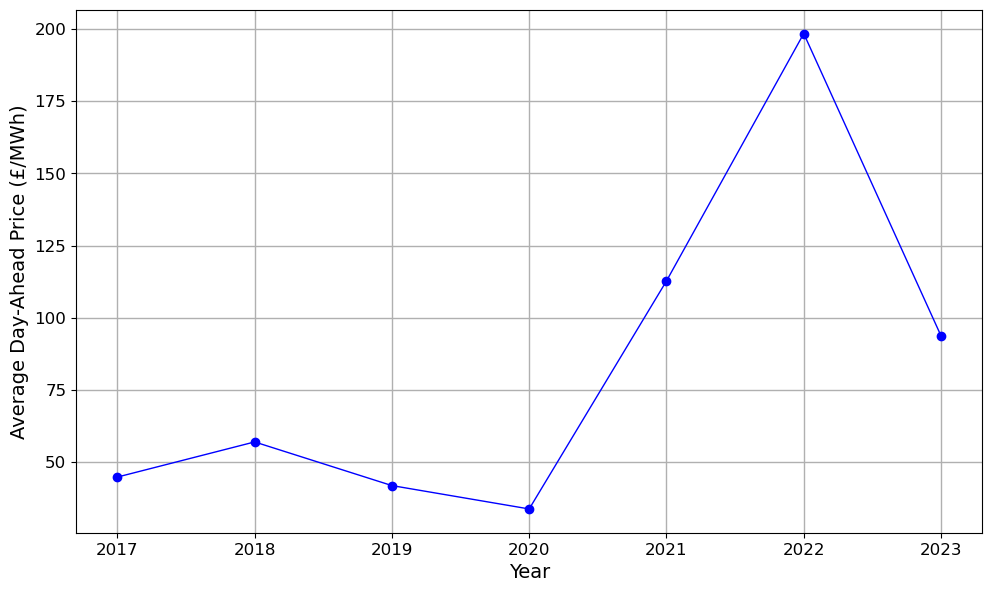

   Year  Average Price (£/MWh)  Growth Rate (%)
0  2017              44.798679              NaN
1  2018              56.972002        27.173397
2  2019              41.852349       -26.538743
3  2020              33.754683       -19.348176
4  2021             112.728997       233.965508
5  2022             198.440638        76.033356
6  2023              93.703914       -52.779877
Compound Annual Growth Rate (CAGR) (2017-2023): 13.09%


In [10]:
# Function to plot the average annual electricity prices and calculate growth rate
def plot_annual_growth(directory, start_year, end_year, image_path, line_width=2):
    annual_prices = []

    for year in range(start_year, end_year + 1):
        # Load data from Excel file
        file_path = f'{directory}/Merged_Electricity_Prices_{year}.xlsx'
        data = pd.read_excel(file_path)
        
        # Calculate annual average price
        annual_avg_price = data['Price (£/MWh)'].mean()
        annual_prices.append((year, annual_avg_price))
    
    # Convert to DataFrame
    annual_prices_df = pd.DataFrame(annual_prices, columns=['Year', 'Average Price (£/MWh)'])
    
    # Calculate annual growth rate
    annual_prices_df['Growth Rate (%)'] = annual_prices_df['Average Price (£/MWh)'].pct_change() * 100
    
    # Calculate CAGR from 2017 to 2023
    V_begin = annual_prices_df.loc[annual_prices_df['Year'] == 2017, 'Average Price (£/MWh)'].values[0]
    V_final = annual_prices_df.loc[annual_prices_df['Year'] == 2023, 'Average Price (£/MWh)'].values[0]
    t = end_year - start_year
    CAGR = ((V_final / V_begin) ** (1 / t) - 1) * 100
    
    # Plot the annual average prices
    plt.figure(figsize=(10, 6))
    plt.plot(annual_prices_df['Year'], annual_prices_df['Average Price (£/MWh)'], marker='o', linestyle='-', color='b', linewidth=line_width)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Average Day-Ahead Price (£/MWh)', fontsize=14)
    plt.grid(True, linewidth=1)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout(pad=1.0)

    # Save plot to file
    plt.savefig(image_path)
    
    # Show plot
    plt.show()
    
    # Print annual growth rate and CAGR
    print(annual_prices_df)
    print(f"Compound Annual Growth Rate (CAGR) (2017-2023): {CAGR:.2f}%")

# Directory to save the Excel files
directory = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Electricity Price'
# Path to save the plot image
image_path = '/Users/qusaialabbassi/Desktop/pythonprojects/Dissertation2/Electricity Price/annual_growth_plot.png'

# Plot the annual growth rate
plot_annual_growth(directory, 2017, 2023, image_path, line_width=1)  # Adjust the line width here
